<a href="https://colab.research.google.com/github/Dimildizio/Adjuface/blob/main/face_extraction/swap_face_dlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swap faces

## Install libs

In [76]:
%%capture
!pip install dlib

## Download essentials

In [ ]:
%%capture
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

## Import libs

In [64]:
import cv2
import dlib
import numpy as np
from pathlib import Path
from typing import Union, Tuple


## Write class for face-swap using dlib and triangulation

In [72]:
class Mask:
    def __init__(self, predictor_path: Path) -> None:
        self._detector = dlib.get_frontal_face_detector()
        self._predictor = dlib.shape_predictor(str(predictor_path))

    def _extract_frame_data(self, img_gray: np.ndarray):
        faces = self._detector(img_gray)
        landmarks_points = []

        for face in faces:
            landmarks = self._predictor(img_gray, face)
            landmarks_points = [(point.x, point.y) for point in landmarks.parts()]
        return {"faces": faces, "landmarks": landmarks_points}


    def _extract_index_nparray(self, nparray: np.ndarray) -> Union[None, np.int64]:
        index = None
        for num in nparray[0]:
            index = num
            break
        return index


    def _triangulate_faces(self, landmarks_points: list) -> dict:
        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)
        cv2.fillConvexPoly(self._mask_empty, convexhull, 255)
        rect = cv2.boundingRect(convexhull)

        subdiv = cv2.Subdiv2D(rect)
        subdiv.insert(landmarks_points)

        triangles = subdiv.getTriangleList()
        triangles = np.array(triangles, dtype=np.int32)

        # generate delaunay triangulations
        indexes_triangles = []
        for t in triangles:
            index_pt1 = np.where((points == t[0:2]).all(axis=1))
            index_pt1 = self._extract_index_nparray(index_pt1)

            index_pt2 = np.where((points == t[2:4]).all(axis=1))
            index_pt2 = self._extract_index_nparray(index_pt2)

            index_pt3 = np.where((points == t[4:6]).all(axis=1))
            index_pt3 = self._extract_index_nparray(index_pt3)

            triangle = [index_pt1, index_pt2, index_pt3]
            if all([pt is not None for pt in triangle]):
                indexes_triangles.append(triangle)
        return {"triangles": triangles, "index": indexes_triangles}


    def set_mask(self, img_path: Path) -> None:
        try:
            self._mask_img = cv2.imread(str(img_path))
            self._mask_img_gray = cv2.cvtColor(self._mask_img, cv2.COLOR_BGR2GRAY)
            self._mask_empty = np.zeros_like(self._mask_img_gray)

            self._mask_handler = self._extract_frame_data(self._mask_img_gray)

            self._triangle_handler = self._triangulate_faces(
                self._mask_handler["landmarks"]
            )
        except cv2.error:
            raise RuntimeError("No face found")


    def process_frame(self, frame: np.ndarray) -> Union[np.ndarray, None]:
        try:
            img2_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_copy = frame.copy()

            self._target_face_handler = self._extract_frame_data(img2_gray)
            frame_face_face = np.zeros_like(frame_copy)

            if len(self._target_face_handler["landmarks"]) > 0:
                points2 = np.array(self._target_face_handler["landmarks"], np.int32)
                convexhull2 = cv2.convexHull(points2)

                for triangle_index in self._triangle_handler["index"]:
                    # Triangulation of the first face
                    tpt1 = self._mask_handler["landmarks"][triangle_index[0]]
                    tpt2 = self._mask_handler["landmarks"][triangle_index[1]]
                    tpt3 = self._mask_handler["landmarks"][triangle_index[2]]
                    triangle1 = np.array([tpt1, tpt2, tpt3], np.int32)

                    x, y, w, h = cv2.boundingRect(triangle1)

                    cropped_triangle = self._mask_img[y:y + h, x:x + w]
                    cropped_tr1_mask = np.zeros((h, w), np.uint8)

                    points = np.array([[tpt1[0] - x, tpt1[1] - y],
                                       [tpt2[0] - x, tpt2[1] - y],
                                       [tpt3[0] - x, tpt3[1] - y]], np.int32)
                    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

                    # Triangulation of second face
                    t2pt1 = self._target_face_handler["landmarks"][triangle_index[0]]
                    t2pt2 = self._target_face_handler["landmarks"][triangle_index[1]]
                    t2pt3 = self._target_face_handler["landmarks"][triangle_index[2]]
                    triangle2 = np.array([t2pt1, t2pt2, t2pt3], np.int32)

                    x, y, w, h = cv2.boundingRect(triangle2)

                    cropped_tr2_mask = np.zeros((h, w), np.uint8)

                    points2 = np.array([[t2pt1[0] - x, t2pt1[1] - y],
                                        [t2pt2[0] - x, t2pt2[1] - y],
                                        [t2pt3[0] - x, t2pt3[1] - y]], np.int32)

                    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

                    # Warp triangles
                    points = np.float32(points)
                    points2 = np.float32(points2)
                    M = cv2.getAffineTransform(points, points2)
                    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
                    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

                    # Reconstructing destination face
                    img2_new_face_rect_area = frame_face_face[y:y + h, x:x + w]
                    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
                    mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)[1]

                    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

                    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
                    frame_face_face[y:y + h, x:x + w] = img2_new_face_rect_area

                # apply face mask
                img2_face_mask = np.zeros_like(img2_gray)
                img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
                img2_face_mask = cv2.bitwise_not(img2_head_mask)
                img2_head_noface = cv2.bitwise_and(frame_copy, frame_copy, mask=img2_face_mask)

                result = cv2.add(img2_head_noface, frame_face_face)
                return result
        except cv2.error:
            pass


## Apply face swap

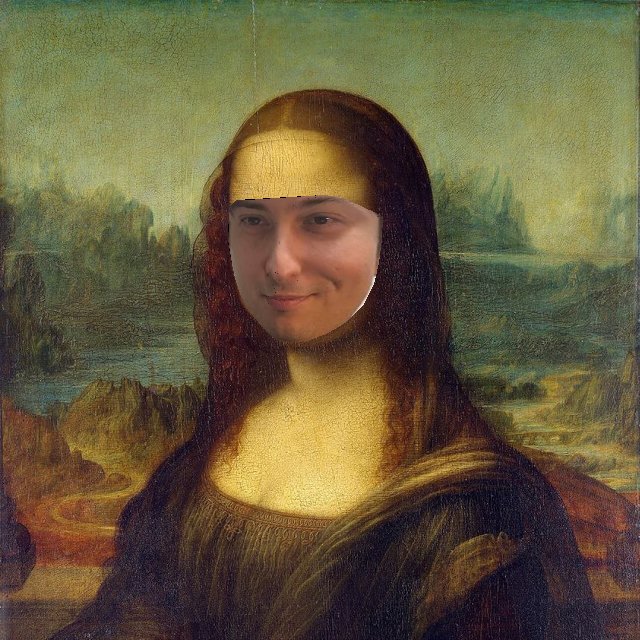

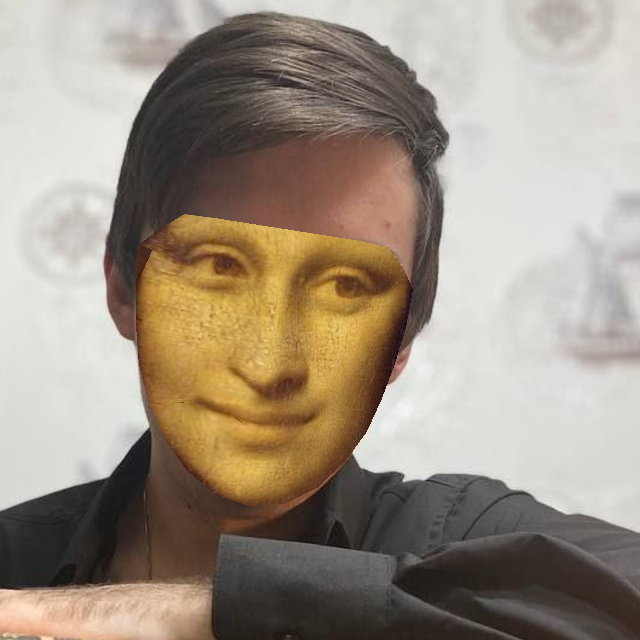

In [75]:
image_path1 = Path("002.png")
image_path2 = Path("mona_lisa.png")

image1 = cv2.imread(str(image_path1))
image2 = cv2.imread(str(image_path2))

faces_mask1 = Mask(predictor_path=Path("shape_predictor_68_face_landmarks.dat"))
faces_mask2 = Mask(predictor_path=Path("shape_predictor_68_face_landmarks.dat"))

faces_mask1.set_mask(image_path1)
faces_mask2.set_mask(image_path2)

swapped_image1 = faces_mask1.process_frame(image2.copy())
swapped_image2 = faces_mask2.process_frame(image1.copy())

cv2_imshow(swapped_image1)
cv2_imshow(swapped_image2)

## Apply style

## Blend faces